# Evaluate segmentation GAN

In [1]:
import os
import re
import numpy as np
import pandas as pd
import skimage
import skimage.io
import time

from torch.utils.data import DataLoader

# 1) Load data

In [2]:
image_dir = "../data/IHC_labeled/h/"
mask_dir = "../data/IHC_labeled/h_mask/"
ihc_labeled_test = pd.read_csv("../data/IHC_labeled/test.txt", sep='.png', header=None)[0].values.tolist()
ihc_labeled_test = [x+".png" for x in ihc_labeled_test if not re.match(r'\*|#', x)]
print("No. labeled test samples = %s" % len(ihc_labeled_test))

No. labeled test samples = 6


/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [3]:
## classes and colors
COLORS = { 'BG':               [255, 255, 255],
           'normal nuclei':    [144,   0, 255],
           'tumor nuclei':     [  0, 255,   0],
           'stroma nuclei':    [255,   0,   0],
           'lymphocyte nuclei':[  0,   0, 255],
           'macrophage nuclei':[255, 255,   0],
           'blood cell':       [255,   0, 255],
           'necrosis':         [  0, 148, 225]
          }
CLASSES = ['tumor nuclei', 'stroma nuclei', 'lymphocyte nuclei', 'blood cell', 'macrophage nuclei', 'necrosis']
LABEL_TO_RGB = dict((class_id+1, COLORS[name]) for class_id, name in enumerate(CLASSES))
RGB_TO_LABEL = dict((tuple(v), k)for k, v in LABEL_TO_RGB.items())
GLOBAL_MEAN = [0.5760583, 0.45498945, 0.57751981]
GLOBAL_STD = [0.24343736, 0.24815826, 0.20826345]

In [4]:
LABEL_TO_RGB

{1: [0, 255, 0],
 2: [255, 0, 0],
 3: [0, 0, 255],
 4: [255, 0, 255],
 5: [255, 255, 0],
 6: [0, 148, 225]}

In [5]:
RGB_TO_LABEL

{(0, 255, 0): 1,
 (255, 0, 0): 2,
 (0, 0, 255): 3,
 (255, 0, 255): 4,
 (255, 255, 0): 5,
 (0, 148, 225): 6}

# 2) Create and check data loader

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
import numpy as np
import math
import skimage
import skimage.transform

import torch
import torch.utils
import torch.utils.data

from utils_image import rgba2rgb, split_masks, Crop, binary_mask_to_polygon

def normalize(image, inverse=False):
    if not inverse:
        image = image/255.
    else:
        image = np.clip(image*255, 0, 255).astype(np.uint8)
    return image

def augmentor(image, label=None):
    """Do image shape and color augmentation.
    
    Args:
        image: [h, w, c], float
    """
    n_channels = image.shape[2]
    
    # Shape augmentation
    if np.random.uniform(0, 1) < 0.8:
        # Projective transform
        scale = np.random.uniform(0.9, 1.1)
        aspect_ratio = np.random.uniform(0.9, 1.1)
        rotation = np.random.uniform(-0.1, 0.1)
        translationX = np.random.uniform(-10, 10)
        translationY = np.random.uniform(-10, 10)
        g = np.random.uniform(-0.001, 0.001)
        h = np.random.uniform(-0.001, 0.001)

        matrix = np.array([[math.cos(rotation) * scale * aspect_ratio, -math.sin(rotation), translationX],
                          [math.sin(rotation), math.cos(rotation) * scale / aspect_ratio, translationY],
                          [g, h, 1]])
        tform = skimage.transform.ProjectiveTransform(matrix=matrix)
        image_aug = np.zeros_like(image, dtype=np.float)
        for ch in range(n_channels):
            image_aug[..., ch] = skimage.transform.warp(image[..., ch], tform, preserve_range=True)
        
        image = image_aug
        
        if label is not None:
            label_aug = np.zeros_like(label, dtype=np.int)
            label_aug = skimage.transform.warp(label, tform, preserve_range=True, order=0)
            label = label_aug
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% vertical flipping
        image = image[::-1, :, :]
        
        if label is not None:
            label = label[::-1, :]
    if np.random.uniform(0, 1) < 0.5:
        # Do 50% horizontal flipping
        image = image[:, ::-1, :]
        
        if label is not None:
            label = label[:, ::-1]

    # Color augmentation
    # 1) add a global shifting for all channels
    image = image + np.random.randn(1)[0] * 0.01

    # 2) add a shifting & variance for each channel
    for ch in range(n_channels):
        image[:, :, ch] = image[:, :, ch] * np.clip(np.random.randn(1)[0] * 0.01 + 1, 0.95, 1.05) + np.random.randn(1)[0] * 0.01
        
    return image, label

def objects_to_tensor_targets(masks, labels, image_id):
    '''
    Args:
        masks: list of [h, w]
        labels: list
    '''
    num_objs = len(labels)
    # masks = [skimage.segmentation.clear_border(_ > 0) for _ in masks]
    masks = [_ > 0 for _ in masks]
    
    bboxes = []
    to_remove = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        if np.max(pos[1]) > np.min(pos[1]) and np.max(pos[0]) > np.min(pos[0]):
            bboxes.append([np.min(pos[1]), np.min(pos[0]), 
                           np.max(pos[1]), np.max(pos[0])])
        else:
            to_remove.append(i)
    bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
    labels = torch.as_tensor([_ for i, _ in enumerate(labels) if i not in to_remove], dtype=torch.int64)
    masks = torch.as_tensor([_ for i, _ in enumerate(masks) if i not in to_remove], dtype=torch.uint8)
    area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
    iscrowd = torch.zeros((num_objs - len(to_remove),), dtype=torch.int64)
    image_id = torch.tensor([image_id])
    
    return {"boxes": bboxes, "labels": labels, "masks": masks, 
            "area": area, "image_id": image_id, "iscrowd": iscrowd}


def add_objects_to_plot(ax, objects, color, label=None):
    # masks = obj['masks'].cpu().detach().numpy()
    # mask_image = np.sum(masks.moveaxis(masks, 0, -1) * labels, axis=-1)
    
    for i, obj in enumerate(objects):
        c = tuple([1.0*_/255 for _ in color[obj['labels']]]) if obj['labels'] else (0, 0, 0)
        if 'masks' in obj:
            polygon = binary_mask_to_polygon(obj['masks'])
            for verts in polygon:
                p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                ax.add_patch(p)
        y1, x1, y2, x2 = obj['boxes']
        b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                      alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
        ax.add_patch(b)
        if 'scores' in obj:
            text = "{}={:.4f}".format(label[obj['labels']], obj['scores'])
            ax.annotate(text, (y1, x2), color=c, weight='bold', )
                        # fontsize=6, ha='center', va='center')

def normal_cell_to_stroma(masks):
    in_val = COLORS['normal nuclei']
    out_val = COLORS['stroma nuclei']
    masks[np.all(masks==in_val, axis=-1), :] = out_val
    return masks

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes_A, indexes_B, image_dict,
                 augmentation=False, crop_size=256, colors=COLORS, val_to_label=RGB_TO_LABEL, 
                 label_to_val=LABEL_TO_RGB):
        """
        Args:
            indexes: index used for image_dict
            indexes_A: IHC
            indexes_B: HE
        """
        self.indexes_A = indexes_A
        self.indexes_B = indexes_B
        self.length_B = len(indexes_B)
        self.image_dict = image_dict
        self.augmentation = augmentation
        self.crop_size = crop_size
        self.colors = colors
        self.val_to_label = val_to_label
        self.label_to_val = label_to_val
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes_A)
    
    def __getitem__(self, index):
        """Generate one batch of data.
        
        Returns:
            idx: indexes of samples (long)
        """
        # Generate indexes of the batch
        data_index_A = self.indexes_A[index]
        np.random.seed()
        idx_B = np.random.choice(np.arange(self.length_B))
        data_index_B = self.indexes_B[idx_B]
        
        # Generate data
        image_A, _ = self.__data_generation(data_index_A, index)
        image_B, target_B = self.__data_generation(data_index_B, idx_B)
        
        data = dict()
        data['A'] = image_A
        data['B'] = image_B
        data['A_paths'] = self.image_dict[data_index_A]['image_path']
        data['B_paths'] = self.image_dict[data_index_B]['image_path']
        data['target_B'] = target_B

        return data
    
    def __data_generation(self, index, idx=0):
        """Generates image containing batch_size samples.
        
        Returns:
            image: [b, ch, h, w]
        """
        image = rgba2rgb(self.image_dict[index]['image'])
        target = self.image_dict[index]['target']
        image_path = self.image_dict[index]['image_path']
        
        # Process target
        if target is not None:
            target = normal_cell_to_stroma(rgba2rgb(target))
            objects = split_masks(target, val_to_label=self.val_to_label, dtype='float')
            target = np.transpose(np.array([x['mask'] for x in objects]), (1, 2, 0))
            labels = [x['label'] for x in objects]
        
        # Augmentation
        if self.augmentation:
            image, target = augmentor(image/255., target)
        else:
            image = image/255.
            
        # Resize
        if self.image_dict[index]['magnitude'] == 20:
            image = skimage.transform.rescale(image, 2, preserve_range=True, multichannel=True, order=1)
            if target is not None:
                target = skimage.transform.rescale(target, 2, preserve_range=True, multichannel=True, order=0)
            
        # Random crop
        image, target = Crop(size=(self.crop_size, self.crop_size), pos='random')([image, target])
        
        # Filter small objects & create target for MaskRCNN
        if target is not None:
            non_zeros = [(target[..., i], labels[i]) for i in range(len(labels)) if np.sum(target[..., i]) > 10]
            if len(non_zeros):
                target, labels = zip(*non_zeros)
            else:
                target = [np.ones((self.crop_size, self.crop_size))]
                labels = [0]
            target = objects_to_tensor_targets(target, labels, idx)
        
        image = torch.tensor(np.transpose(image, (2, 0, 1)).astype(float))
        
        return image, target
    
    def display(self, indices=None):
        if indices is None:
            indices = range(len(self))
        elif isinstance(indices, int):
            indices = np.random.choice(len(self), indices)
        for i in indices:
            data = self[i]
            image = data['B']
            targets = data['target_B']
            image = image.permute(1, 2, 0).numpy()
            if targets is not None:
                bboxes = targets['boxes'].numpy()
                labels = targets['labels'].numpy()
                masks = targets['masks'].numpy()
            
            fig, ax = plt.subplots(1, 2, figsize=(6 * 2, 6))
            ax[0].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            ax[1].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
            if targets is not None:
                color = self.label_to_val
                for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                    c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                    polygon = binary_mask_to_polygon(mask)
                    for verts in polygon:
                        p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                        ax[1].add_patch(p)
                    y1, x1, y2, x2 = bbox
                    b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                                  alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                    ax[1].add_patch(b)

            plt.show()
            
def collate_fn(batch):
    return list(batch)

# 3) Create model

In [7]:
from collections import OrderedDict
import warnings

import torch
from torch import nn, Tensor
from torch.jit.annotations import Tuple, List, Dict, Optional
import torch.nn.functional as F
import torchvision.models.detection as tmdet

from torch_layers import deep_update, BoxPredictor, MaskPredictor, KeypointPredictor

class TransferRCNN(nn.Module):
    """
    MaskRCNN for segmentation and style transfer.
    Arguments:
        backbone (nn.Module):
        rpn (nn.Module):
        roi_heads (nn.Module): takes the features + the proposals from the RPN and computesdetections / masks from it.
        transform (nn.Module): performs the data transformation from the inputs to feed into the model & postprocess.
    """

    def __init__(self, backbone, num_classes, masks=False, keypoints=None, 
                 config={}, pretrained=False):
        super(TransferRCNN, self).__init__()
        self.config = self.default_config(num_classes, masks, keypoints)
        deep_update(self.config, config)
        self.config['featmap_names'] = self.config['featmap_names'] or backbone.featmap_names
        self.config['in_channels'] = self.config['in_channels'] or backbone.out_channels
        
        self.rpn = self.get_rpn()
        self.roi_heads = self.get_roi_heads()
        self.transfer_heads = self.get_transfer_heads()
        self.transform = self.get_transform()
        self.backbone = backbone
        # used only on torchscript mode
        self._has_warned = False
        
        if pretrained:
            self.load_pretrain(pretrained)

    @torch.jit.unused
    def eager_outputs(self, losses, detections, transfered_images):
        # type: (Dict[str, Tensor], List[Dict[str, Tensor]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        if self.training:
            return losses

        return detections, transfered_images

    def forward(self, images, targets=None):
        # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
        """
        Arguments:
            images (list[Tensor]): images to be processed
            targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)
        Returns:
            result (list[BoxList] or dict[Tensor]): the output from the model.
                During training, it returns a dict[Tensor] which contains the losses.
                During testing, it returns list[BoxList] contains additional fields
                like `scores`, `labels` and `mask` (for Mask R-CNN models).
        """
        if self.training and targets is None:
            raise ValueError("In training mode, targets should be passed")
        if self.training:
            assert targets is not None
            for target in targets:
                boxes = target["boxes"]
                if isinstance(boxes, torch.Tensor):
                    if len(boxes.shape) != 2 or boxes.shape[-1] != 4:
                        raise ValueError("Expected target boxes to be a tensor"
                                         "of shape [N, 4], got {:}.".format(
                                             boxes.shape))
                else:
                    raise ValueError("Expected target boxes to be of type "
                                     "Tensor, got {:}.".format(type(boxes)))

        original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
        for img in images:
            val = img.shape[-2:]
            assert len(val) == 2
            original_image_sizes.append((val[0], val[1]))

        images, targets = self.transform(images, targets)

        # Check for degenerate boxes
        # TODO: Move this to a function
        if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenrate box
                    bb_idx = degenerate_boxes.any(dim=1).nonzero().view(-1)[0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    raise ValueError("All bounding boxes should have positive height and width."
                                     " Found invaid box {} for target at index {}."
                                     .format(degen_bb, target_idx))

        features = self.backbone(images.tensors)
        if isinstance(features, torch.Tensor):
            features = OrderedDict([('0', features)])
        proposals, proposal_losses = self.rpn(images, features, targets)
        detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
        transfered_images = self.transfer_heads(features['0'])
        detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)

        if torch.jit.is_scripting():
            if not self._has_warned:
                warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
                self._has_warned = True
            return (losses, detections, transfered_images)
        else:
            return (losses, detections, transfered_images)
            # return self.eager_outputs(losses, detections, transfered_images)
    
    def get_transform(self):
        return tmdet.transform.GeneralizedRCNNTransform(**self.config['transform'])
    
    def get_rpn(self):
        in_channels = self.config['in_channels']
        rpn_params = self.config['rpn_params']
        
        rpn_anchor = tmdet.rpn.AnchorGenerator(**rpn_params['anchor'])
        rpn_header = tmdet.rpn.RPNHead(in_channels, rpn_anchor.num_anchors_per_location()[0])
        rpn = tmdet.rpn.RegionProposalNetwork(rpn_anchor, rpn_header, **rpn_params['rpn'])
        
        return rpn
    
    def get_roi_heads(self):
        featmap_names = self.config['featmap_names']
        in_channels = self.config['in_channels']
        roi_params = self.config['roi_params']
        
        ## box header
        box_header = BoxPredictor(in_channels, featmap_names, **roi_params['box'])
        
        ## roi heads
        roi_heads = tmdet.roi_heads.RoIHeads(
            box_roi_pool=box_header.box_roi_pool,
            box_head=box_header.box_head,
            box_predictor=box_header.box_predictor,
            **roi_params['roi']
        )
        
        ## add mask header
        if 'mask' in roi_params:
            mask_header = MaskPredictor(in_channels, featmap_names, **roi_params['mask'])
            roi_heads.mask_roi_pool = mask_header.mask_roi_pool
            roi_heads.mask_head = mask_header.mask_head
            roi_heads.mask_predictor = mask_header.mask_predictor
        
        ## add keypoint header
        if 'keypoint' in roi_params:
            keypoint_header = KeypointPredictor(in_channels, featmap_names, **roi_params['keypoint'])
            roi_heads.keypoint_roi_pool = keypoint_header.keypoint_roi_pool
            roi_heads.keypoint_head = keypoint_header.keypoint_head
            roi_heads.keypoint_predictor = keypoint_header.keypoint_predictor
        
        return roi_heads
    
    def get_transfer_heads(self):
        fpn_channels = self.config['fpn_params']['out_channels']
        transfer_params = self.config['transfer_params']
        return TransferHead(fpn_channels, **transfer_params)
        
    
    def load_pretrain(self, pretrained):
        if isinstance(pretrained, str):
            weights = torch.load(pretrained)
        else:
            if self.roi_heads.has_mask():
                m = tmdet.maskrcnn_resnet50_fpn(
                    pretrained=True, progress=False, pretrained_backbone=False)
            elif self.roi_heads.has_keypoint():
                m = tmdet.keypointrcnn_resnet50_fpn(
                    pretrained=True, progress=False, pretrained_backbone=False)
            else:
                m = tmdet.fasterrcnn_resnet50_fpn(
                    pretrained=True, progress=False, pretrained_backbone=False)
            weights = m.state_dict()
        
        try:
            # remove backbone from state_dict
            w = {k: v for k, v in weights.items() 
                 if not k.startswith('backbone.body')}
            self.load_state_dict(w, strict=False)
        except RuntimeError as e:
            print(e)

    def default_config(self, num_classes, masks, keypoints):
        config = {
            ## backbone
            'featmap_names': None,
            'in_channels': None,
            ## fpn
            'fpn_params':{
                'out_channels': 256,
            },
            ## rpn
            'rpn_params': {
                'anchor': {
                    'sizes': [[32], [64], [128], [256], [512]],
                    'aspect_ratios': [[0.5, 1.0, 2.0]] * 5,
                }, 
                'rpn': {
                    'fg_iou_thresh': 0.7, 
                    'bg_iou_thresh': 0.3,
                    'batch_size_per_image': 256, 
                    'positive_fraction': 0.5,

                    'pre_nms_top_n': {'training': 2000, 'testing': 1000},
                    'post_nms_top_n': {'training': 2000, 'testing': 1000},
                    'nms_thresh': 0.7,
                },
            },
            ## roi
            'roi_params': {
                ## roi predictor
                'roi': {
                    # Faster R-CNN training
                    'fg_iou_thresh': 0.5, 
                    'bg_iou_thresh': 0.5,
                    'batch_size_per_image': 512, 
                    'positive_fraction': 0.25,
                    'bbox_reg_weights': None,
                    # Faster R-CNN inference
                    'score_thresh': 0.05, 
                    'nms_thresh': 0.5, 
                    'detections_per_img': 100,
                },
                ## box predictor
                'box': {
                    'num_classes': num_classes,
                    'roi_output_size': 7, 
                    'roi_sampling_ratio': 2,
                    'layers': [1024, 1024], 
                },
            },
            ## transfer
            'transfer_params':{
                'in_channels': 64,
                'out_channels': 3,
                'up_scales': [2, 2],
            },
            ## transform
            'transform': {
                'min_size': 800, 'max_size': 1333, 
                'image_mean': [0.485, 0.456, 0.406], 'image_std': [0.229, 0.224, 0.225],
            }
        }
        if masks:
            ## mask predictor
            config['roi_params']['mask'] = {
                'num_classes': num_classes,
                'roi_output_size': 14, 
                'roi_sampling_ratio': 2,
                'layers': [256, 256, 256, 256],
                'dilation': 1,
                'dim_reduced': 256,
            }
        if keypoints:
            ## keypoint predictor
            config['roi_params']['keypoint'] = {
                'num_keypoints': keypoints,
                'roi_output_size': 14, 
                'roi_sampling_ratio': 2,
                'layers': [512] * 8,
            }

        return config
    
class TransferHead(nn.Module):
    def __init__(self, fpn_channels, in_channels, out_channels, up_scales):
        super(TransferHead, self).__init__()
        transfer_block = [nn.Conv2d(fpn_channels, in_channels, kernel_size=1, padding=0)]
        transfer_block.extend([UpsampleBLock(in_channels, up_scale) for up_scale in up_scales])
        transfer_block.append(nn.Conv2d(in_channels, out_channels, kernel_size=9, padding=4))
        self.transfer_block = nn.Sequential(*transfer_block)
        self.mse_loss = nn.MSELoss()
    
    def forward(self, x, targets=None):
        x = self.transfer_block(x)
        x = (F.tanh(x) + 1)/2
        
        '''
        losses = {}
        if self.training:
            assert targets is not None
            losses = {
                "loss_transfer_image": self.mse_loss(x, targets),
            }
        '''
        return x
    
class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.bn = nn.BatchNorm2d(in_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

In [8]:
## Model Config
# MODEL_DIR = "./models/maskrcnn_resnet101_fpn256_512"
# MODEL_NAME = 'maskrcnn_resnet101_fpn256'
# MODEL_INPUT_SIZE = (256, 256)
MODEL_CONFIG = {
    'transform': {
        'min_size': 512, 'max_size': 512, 
        'image_mean': [0.0, 0.0, 0.0], 'image_std': [1.0, 1.0, 1.0],
    }, 
    ## roi
    'roi_params': {
        ## roi predictor
        'roi': {
            # Faster R-CNN training
            'fg_iou_thresh': 0.5, 
            'bg_iou_thresh': 0.5,
            'batch_size_per_image': 512, 
            'positive_fraction': 0.25,
            'bbox_reg_weights': None,
            # Faster R-CNN inference
            'score_thresh': 0.05, 
            'nms_thresh': 0.5, 
            'detections_per_img': 500,
        },
    },
}

# resnet_fpn_A = tmdet.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
# resnet_fpn_A.featmap_names = ['0', '1', '2', '3']
# resnet_fpn_B = tmdet.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
# resnet_fpn_B.featmap_names = ['0', '1', '2', '3']
# NET = TransferRCNN(resnet_fpn_A, num_classes=len(CLASSES)+1, 
#            masks=True, config=MODEL_CONFIG, pretrained=True)

In [9]:
import torch
import itertools
from util.image_pool import ImagePool

# Self defined functions
from base_model import BaseModel
import networks


class SegCycleGANModel(BaseModel):
    """
    This class implements the SegCycleGAN model, for learning image-to-image translation without paired data 
    and learning segmentation at the same time.
    The model training requires '--dataset_mode unaligned' dataset.
    By default, it uses a '--netG resnet_9blocks' ResNet generator,
    a '--netD basic' discriminator (PatchGAN introduced by pix2pix),
    and a least-square GANs objective ('--gan_mode lsgan').
    CycleGAN paper: https://arxiv.org/pdf/1703.10593.pdf
    """
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options.
        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or 
                               test-specific options.
        Returns:
            the modified parser.
        For CycleGAN, in addition to GAN losses, we introduce lambda_A, lambda_B, and lambda_identity for the following losses.
        A (source domain), B (target domain).
        Generators: G_A: A -> B; G_B: B -> A.
        Discriminators: D_A: G_A(A) vs. B; D_B: G_B(B) vs. A.
        Forward cycle loss:  lambda_A * ||G_B(G_A(A)) - A|| (Eqn. (2) in the paper)
        Backward cycle loss: lambda_B * ||G_A(G_B(B)) - B|| (Eqn. (2) in the paper)
        Identity loss (optional): lambda_identity * (||G_A(B) - B|| * lambda_B + ||G_B(A) - A|| * lambda_A) 
                                  (Sec 5.2 "Photo generation from paintings" in the paper)
        Dropout is not used in the original CycleGAN paper.
        """
        parser.set_defaults(no_dropout=True)  # default CycleGAN did not use dropout
        if is_train:
            parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
            parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
            parser.add_argument('--lambda_identity', type=float, default=0.5, help='''use identity mapping. 
Setting lambda_identity other than 0 has an effect of scaling the weight of the 
identity mapping loss. For example, if the weight of the identity loss should be 
10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1''')

        return parser

    def __init__(self, opt, threshold):
        """Initialize the CycleGAN class.
        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
            threshold: threshold for filtering out low confidence objects
        """
        BaseModel.__init__(self, opt)
        self.threshold = threshold
        
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['D_A', 'G_A', 'cycle_A', 'idt_A', 'D_B', 'G_B', 'cycle_B', 'idt_B']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        visual_names_A = ['real_A', 'fake_B', 'rec_A']
        visual_names_B = ['real_B', 'fake_A', 'rec_B']
        if self.isTrain and self.opt.lambda_identity > 0.0:  # if identity loss is used, we also visualize idt_B=G_A(B) ad idt_A=G_A(B)
            visual_names_A.append('idt_B')
            visual_names_B.append('idt_A')

        self.visual_names = visual_names_A + visual_names_B  # combine visualizations for A and B
        # specify the models you want to save to the disk. 
        # The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>.
        if self.isTrain:
            self.model_names = ['G_A', 'G_B', 'D_A', 'D_B']
        else:  # during test time, only load Gs
            self.model_names = ['G_A', 'G_B']

        # define networks (both Generators and discriminators)
        # The naming is different from those used in the paper.
        # Code (vs. paper): G_A (G), G_B (F), D_A (D_Y), D_B (D_X)
        '''
        self.netG_A = networks.define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)
        self.netG_B = networks.define_G(opt.output_nc, opt.input_nc, opt.ngf, opt.netG, opt.norm,
                                        not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)
        '''
        resnet_fpn_A = tmdet.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
        resnet_fpn_A.featmap_names = ['0', '1', '2', '3']
        resnet_fpn_B = tmdet.backbone_utils.resnet_fpn_backbone('resnet50', pretrained=True)
        resnet_fpn_B.featmap_names = ['0', '1', '2', '3']
        self.netG_A = TransferRCNN(resnet_fpn_A, num_classes=len(CLASSES)+1, masks=True, config=MODEL_CONFIG, pretrained=True)
        self.netG_B = TransferRCNN(resnet_fpn_B, num_classes=len(CLASSES)+1, masks=True, config=MODEL_CONFIG, pretrained=True)
        self.netG_A = self.netG_A.to(self.gpu_ids[0])
        self.netG_B = self.netG_B.to(self.gpu_ids[0])

        if self.isTrain:  # define discriminators
            self.netD_A = networks.define_D(opt.output_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)
            self.netD_B = networks.define_D(opt.input_nc, opt.ndf, opt.netD,
                                            opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            if opt.lambda_identity > 0.0:  # only works when input and output images have the same number of channels
                assert(opt.input_nc == opt.output_nc)
            self.fake_A_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
            self.fake_B_pool = ImagePool(opt.pool_size)  # create image buffer to store previously generated images
            # define loss functions
            self.criterionGAN = networks.GANLoss(opt.gan_mode).to(self.device)  # define GAN loss.
            self.criterionCycle = torch.nn.L1Loss()
            self.criterionIdt = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), 
                                                lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), 
                                                lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, data):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        Parameters:
            input (dict): include the data itself and its metadata information.
        The option 'direction' can be used to swap domain A and domain B.
        A: IHC
        B: HE
        """
        AtoB = self.opt.direction == 'AtoB'
        self.real_A = torch.stack([_['A' if AtoB else 'B'] for _ in data]).float().to(self.device)
        self.real_B = torch.stack([_['B' if AtoB else 'A'] for _ in data]).float().to(self.device)
        self.image_paths = [_['A_paths' if AtoB else 'B_paths'] for _ in data]
        for _ in data:
            if _['target_B'] is not None:
                for key in list(_['target_B'].keys()):
                    _['target_B'][key] = _['target_B'][key].to(self.device)
        self.target_B = [_['target_B'] for _ in data]

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.netG_B.eval()
        self.netG_A.eval()
        _, _, self.fake_B = self.netG_A(self.real_A)
        _, self.target_A, _ = self.netG_B(self.fake_B)
        for i, _ in enumerate(self.target_A):
            self.target_A[i] = self.filter_detections(_)
        for i, _ in enumerate(self.target_B):
            if _ is None:
                _, _temp_target_B, _ = self.netG_B(self.real_B[i:i+1, ...])
                _temp_target_B = self.filter_detections(_temp_target_B[0])
                self.target_B[i] = _temp_target_B
        
        self.netG_A.train()
        self.netG_B.train()
        # Only use mask_loss_real_A & mask_loss_real_B & mask_loss_fake_A
        self.mask_loss_real_A, self.mask_pred_real_A, self.fake_B = self.netG_A(self.real_A, self.target_A)
        self.mask_loss_fake_B, self.mask_pred_fake_B, self.rec_A = self.netG_B(self.fake_B, self.target_A)
        self.mask_loss_real_B, self.mask_pred_real_B, self.fake_A = self.netG_B(self.real_B, self.target_B)
        self.mask_loss_fake_A, self.mask_pred_fake_A, self.rec_B = self.netG_A(self.fake_A, self.target_B)
        
        # self.fake_B = self.netG_A(self.real_A)  # G_A(A)
        # self.rec_A = self.netG_B(self.fake_B)   # G_B(G_A(A))
        # self.fake_A = self.netG_B(self.real_B)  # G_B(B)
        # self.rec_B = self.netG_A(self.fake_A)   # G_A(G_B(B))

    def backward_D_basic(self, netD, real, fake, val=False):
        """Calculate GAN loss for the discriminator
        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator
        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
        """
        # Real
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # Fake
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # Combined loss and calculate gradients
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        if not val:
            loss_D.backward()
        return loss_D

    def backward_D_A(self, val=False):
        """Calculate GAN loss for discriminator D_A"""
        fake_B = self.fake_B_pool.query(self.fake_B)
        self.loss_D_A = self.backward_D_basic(self.netD_A, self.real_B, fake_B, val=val)

    def backward_D_B(self, val=False):
        """Calculate GAN loss for discriminator D_B"""
        fake_A = self.fake_A_pool.query(self.fake_A)
        self.loss_D_B = self.backward_D_basic(self.netD_B, self.real_A, fake_A, val=val)

    def backward_G(self, val=False):
        """Calculate the loss for generators G_A and G_B"""
        lambda_idt = self.opt.lambda_identity
        lambda_A = self.opt.lambda_A
        lambda_B = self.opt.lambda_B
        # Identity loss
        if lambda_idt > 0:
            # G_A should be identity if real_B is fed: ||G_A(B) - B||
            _, _, self.idt_A = self.netG_A(self.real_B, self.target_B)
            self.loss_idt_A = self.criterionIdt(self.idt_A, self.real_B) * lambda_B * lambda_idt
            # G_B should be identity if real_A is fed: ||G_B(A) - A||
            _, _, self.idt_B = self.netG_B(self.real_A, self.target_A)
            self.loss_idt_B = self.criterionIdt(self.idt_B, self.real_A) * lambda_A * lambda_idt
        else:
            self.loss_idt_A = 0
            self.loss_idt_B = 0

        # GAN loss D_A(G_A(A))
        self.loss_G_A = self.criterionGAN(self.netD_A(self.fake_B), True)
        # GAN loss D_B(G_B(B))
        self.loss_G_B = self.criterionGAN(self.netD_B(self.fake_A), True)
        # Forward cycle loss || G_B(G_A(A)) - A||
        self.loss_cycle_A = self.criterionCycle(self.rec_A, self.real_A) * lambda_A
        # Backward cycle loss || G_A(G_B(B)) - B||
        self.loss_cycle_B = self.criterionCycle(self.rec_B, self.real_B) * lambda_B
        # combined loss and calculate gradients
        self.loss_G = self.loss_G_A + self.loss_G_B + self.loss_cycle_A + self.loss_cycle_B + self.loss_idt_A + self.loss_idt_B + \
                        sum(loss for loss in self.mask_loss_real_B.values()) + \
                        sum(loss for loss in self.mask_loss_fake_A.values()) + sum(loss for loss in self.mask_loss_real_A.values())
        
        if not val:
            self.loss_G.backward()

    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute fake images and reconstruction images.
        # G_A and G_B
        self.set_requires_grad([self.netD_A, self.netD_B], False)  # Ds require no gradients when optimizing Gs
        self.optimizer_G.zero_grad()  # set G_A and G_B's gradients to zero
        self.backward_G()             # calculate gradients for G_A and G_B
        self.optimizer_G.step()       # update G_A and G_B's weights
        # D_A and D_B
        self.set_requires_grad([self.netD_A, self.netD_B], True)
        self.optimizer_D.zero_grad()   # set D_A and D_B's gradients to zero
        self.backward_D_A()      # calculate gradients for D_A
        self.backward_D_B()      # calculate graidents for D_B
        self.optimizer_D.step()  # update D_A and D_B's weights
        
    def forward_wo_optimize_parameters(self):
        """Calculate losses in validation set, run within torch.no_grad()"""
        # forward
        self.forward()
        
        # G_A and G_B
        self.backward_G(val=True)
        
        # D_A and D_B
        self.backward_D_A(val=True)      # calculate gradients for D_A
        self.backward_D_B(val=True) 
        
    def save_networks(self, epoch):
        """Save all the networks to the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if isinstance(net, torch.nn.DataParallel):
                    torch.save(net.module.state_dict(), save_path)
                else:
                    torch.save(net.state_dict(), save_path)

    def load_networks(self, epoch):
        """Load all the networks from the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                # for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                #     self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
                
    def filter_detections(self, det):
        """Filter out maskrcnn detetions with low confidence."""
        if 'scores' in det.keys():
            _scores = det['scores']
            if torch.sum(_scores > self.threshold) > 0:
                det['boxes'] = torch.stack([det['boxes'][i, ...] for i in range(len(_scores)) 
                                            if _scores[i] >= self.threshold]).to(self.device)
                det['labels'] = torch.stack([det['labels'][i, ...] for i in range(len(_scores)) 
                                             if _scores[i] >= self.threshold]).to(self.device)
                det['masks'] = torch.stack([det['masks'][i, ...] for i in range(len(_scores)) 
                                            if _scores[i] >= self.threshold]).to(self.device)
                det['scores'] = torch.stack([_ for _ in _scores if _ >= self.threshold]).to(self.device)
            else:
                det['boxes'] = torch.empty(0, 4, dtype=torch.float32).to(self.device)
                det['labels'] = torch.tensor([], dtype=torch.int64).to(self.device)
                det['masks'] = torch.empty(0, opt.crop_size, opt.crop_size, dtype=torch.uint8).to(self.device)
                det['scores'] = torch.tensor([], dtype=torch.float32).to(self.device)
        return det

In [12]:
import time
from options.test_options import TestOptions

opt = TestOptions().parse(['--dataroot', '.', 
                            '--batch_size', '5', 
                            '--checkpoints_dir', './models',
                            '--crop_size', '512',
                            '--name', "curriculum_256_09082020",
                            '--epoch', "420", 
                            '--gpu_ids', '0',
                            # '--print_freq', '30', 
                            # '--lr', '0.0002', 
                            # '--n_epochs', '400'
                          ], SegCycleGANModel)

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 5                             	[default: 1]
          checkpoints_dir: ./models                      	[default: ./checkpoints]
                crop_size: 512                           	[default: 256]
                 dataroot: .                             	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: 420                           	[default: latest]
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[

In [13]:
model = SegCycleGANModel(opt, threshold=0.5)
model.setup(opt)

Error(s) in loading state_dict for TransferRCNN:
	size mismatch for roi_heads.box_predictor.cls_score.weight: copying a param with shape torch.Size([91, 1024]) from checkpoint, the shape in current model is torch.Size([7, 1024]).
	size mismatch for roi_heads.box_predictor.cls_score.bias: copying a param with shape torch.Size([91]) from checkpoint, the shape in current model is torch.Size([7]).
	size mismatch for roi_heads.box_predictor.bbox_pred.weight: copying a param with shape torch.Size([364, 1024]) from checkpoint, the shape in current model is torch.Size([28, 1024]).
	size mismatch for roi_heads.box_predictor.bbox_pred.bias: copying a param with shape torch.Size([364]) from checkpoint, the shape in current model is torch.Size([28]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_logits.weight: copying a param with shape torch.Size([91, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([7, 256, 1, 1]).
	size mismatch for roi_heads.mask_predictor.mask_fcn_

In [14]:
# Load model
model.load_networks(560)

loading the model from ./models/curriculum_256_09082020/560_net_G_A.pth
loading the model from ./models/curriculum_256_09082020/560_net_G_B.pth


# 4) Run & plot testing results

In [15]:
def display_segmentation(r, val_to_rgb):
    """Display segmentation result.
    
    Args:
        r: model.detect[0]
        val_to_rgb: dict
    """
    masks = r['masks']
    class_ids = r['labels']
    mask = np.zeros((masks.shape[1], masks.shape[2], 3), dtype=np.uint8)
    mask[:, :] = [255, 255, 255]
    for i in range(masks.shape[0]):
        mask[masks[i, :, :] >= 0.95] = val_to_rgb[class_ids[i]]
    plt.imshow(mask)
    
def display(image, targets, show_ori=False, label_to_val=LABEL_TO_RGB, threshold=0.0):
    """
    Args:
        image: range 0-1, 3 channels
    """
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).detach().cpu().numpy()
    if targets is not None:
        bboxes = targets['boxes']
        labels = targets['labels']
        masks = targets['masks']
        scores = None
        if 'scores' in list(targets.keys()):
            scores = targets['scores']
        if isinstance(bboxes, torch.Tensor):
            bboxes = bboxes.detach().cpu().numpy()
        if isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
        if isinstance(masks, torch.Tensor):
            masks = masks.detach().cpu().numpy()
        if isinstance(scores, torch.Tensor):
            scores = scores.detach().cpu().numpy()
        if len(masks.shape) == 4:
            masks = masks[:, 0, ...]
        
        # Remove according to threshold
        if scores is not None:
            bboxes = [_ for i, _ in enumerate(bboxes) if scores[i] >= threshold]
            labels = [_ for i, _ in enumerate(labels) if scores[i] >= threshold]
            masks = [_ for i, _ in enumerate(masks) if scores[i] >= threshold]
    
    if show_ori:
        fig, ax = plt.subplots(1, 2, figsize=(6 * 2, 6))
        ax[0].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
        ax[1].imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
        if targets is not None:
            color = label_to_val
            for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                polygon = binary_mask_to_polygon(mask)
                for verts in polygon:
                    p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                    ax[1].add_patch(p)
                y1, x1, y2, x2 = bbox
                b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                              alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                ax[1].add_patch(b)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(np.array(np.clip(image * 255, 0, 255), dtype=np.uint8))
        if targets is not None:
            color = label_to_val
            for i, (mask, bbox, label) in enumerate(zip(masks, bboxes, labels)):
                c = tuple([1.0*_/255 for _ in color[label]]) if label else (0, 0, 0)
                polygon = binary_mask_to_polygon(mask)
                for verts in polygon:
                    p = Polygon(np.array(verts[:, ::-1]), facecolor="none", edgecolor=c)
                    ax.add_patch(p)
                y1, x1, y2, x2 = bbox
                b = Rectangle((y1, x1), (y2-y1), (x2-x1), linewidth=2,
                              alpha=0.5, linestyle="solid", edgecolor=c, facecolor="none")
                ax.add_patch(b)
                
                if scores is not None:
                    score = scores[i]
                    ax.text(y1, x2, np.round(score, 2), color=(1, 1, 1))

    plt.show()
    
def preprocess(image, image_size=512):
    ori_image_size = image.shape[0]
    if ori_image_size < image_size:
        # Padding
        _image = np.zeros([image_size, image_size, 3])
        _image[0:image.shape[0], 0:image.shape[1], :] = image
    else:
        _image = image
    return torch.tensor(np.transpose(_image/255., (2, 0, 1))).float()
    
def postprocess(targets, threshold=0.5, ori_image_size=500):
    if 'scores' in targets.keys():
        _scores = targets['scores']
        if torch.sum(_scores > threshold) > 0:
            targets['boxes'] = torch.stack([targets['boxes'][i, ...] for i in range(len(_scores)) 
                                        if _scores[i] >= threshold])
            targets['labels'] = torch.stack([targets['labels'][i, ...] for i in range(len(_scores)) 
                                         if _scores[i] >= threshold])
            targets['masks'] = torch.stack([targets['masks'][i, ...] for i in range(len(_scores)) 
                                        if _scores[i] >= threshold])
            targets['scores'] = torch.stack([_ for _ in _scores if _ >= threshold])
        else:
            targets['boxes'] = torch.empty(0, 4, dtype=torch.float32)
            targets['labels'] = torch.tensor([], dtype=torch.int64)
            targets['masks'] = torch.empty(0, opt.crop_size, opt.crop_size, dtype=torch.uint8)
            targets['scores'] = torch.tensor([], dtype=torch.float32)
    
    masks = np.array(targets['masks'].cpu().numpy() > 0.55, dtype=int)
    if len(masks.shape) == 4:
        masks = masks[:, 0, ...]
    image_size = masks.shape[1]
    if ori_image_size < image_size:
        masks = masks[:, 0:ori_image_size, 0:ori_image_size]
    boxes = targets['boxes'].cpu().numpy()
    labels = targets['labels'].cpu().numpy()
    occlusion = np.ones(np.shape(masks)[1:3])
    to_keep = []
    for j in range(masks.shape[0]):
        # Remove the mask with tooooo much overlapping with previously detected region
        original_area = np.sum(masks[j, :, :])
        masks[j, :, :] = masks[j, :, :] * occlusion
        new_area = np.sum(masks[j, :, :])
        if new_area > 0 and new_area/original_area > 0.6:
            to_keep.append(True)
            occlusion = np.logical_and(occlusion, np.logical_not(masks[j, :, :]))
        else:
            to_keep.append(False)
   
    targets['boxes'] = boxes[to_keep]
    targets['masks'] = masks[to_keep, :, :]
    targets['labels'] =labels[to_keep]
    if 'scores' in targets.keys():
        targets['score'] = targets['scores'].cpu().numpy()[to_keep]
        
    return targets

0 MDA LUAD-9 PD-L1 Tumor Microenviroment Prospect ADC-001.svs_6273.679700053562x16049.947572815534.png


/home2/swan15/.local/lib/python3.6/site-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)
/home2/swan15/.local/lib/python3.6/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


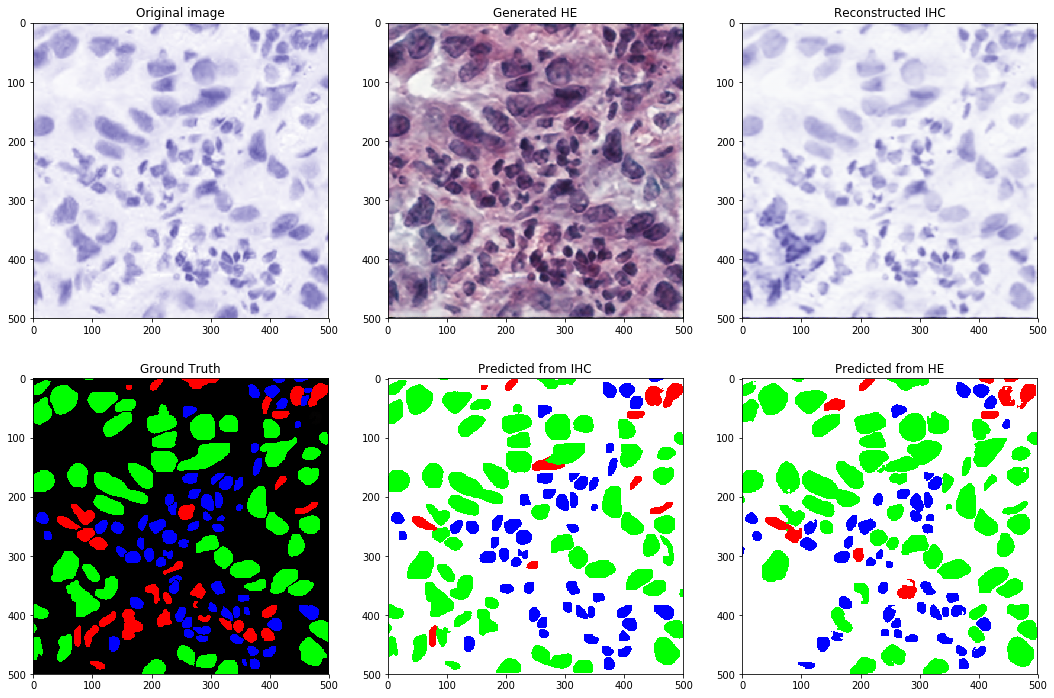

1 MDA LUAD-9 PD-L1 Tumor Microenviroment Prospect ADC-001.svs_10658.85377611141x11793.431067961164.png


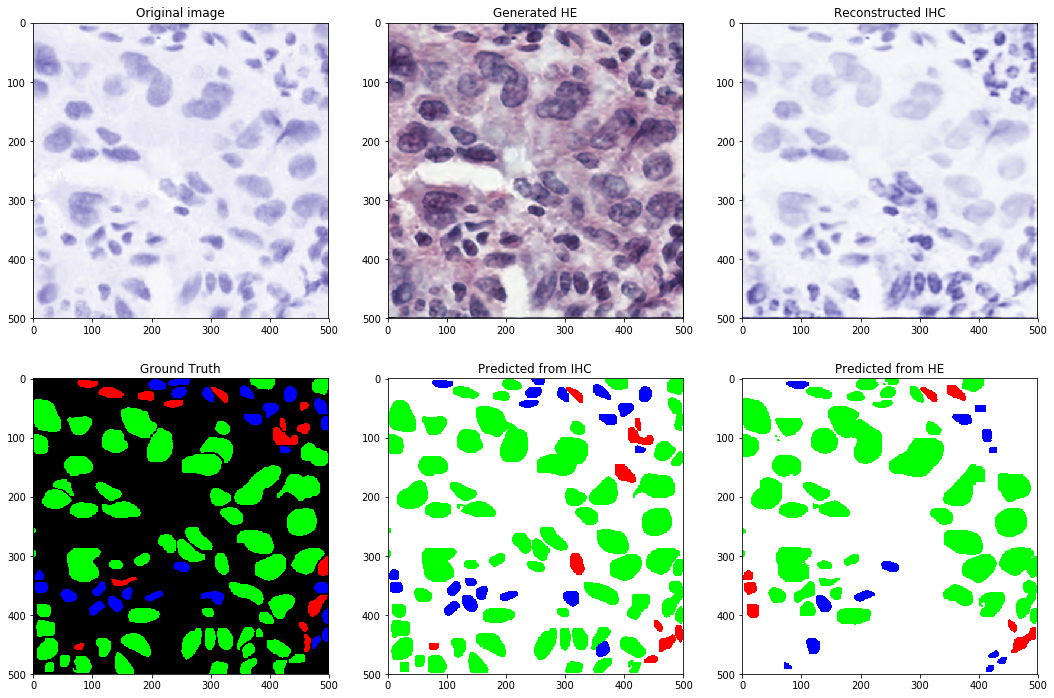

2 MDA LUAD-9 PD-L1 Tumor Microenviroment Prospect ADC-001.svs_14259.81788966256x13633.654368932039.png


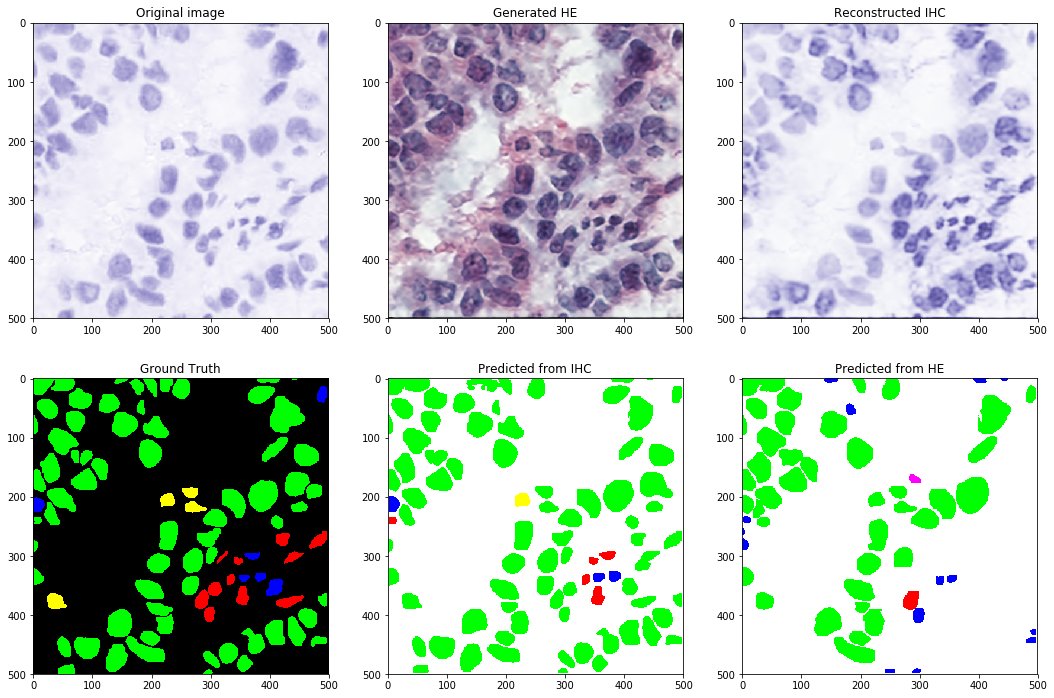

3 MDA LUAD-9 PD-L1 Tumor Microenviroment Prospect ADC-001.svs_15396.122121049813x13809.675728155338.png


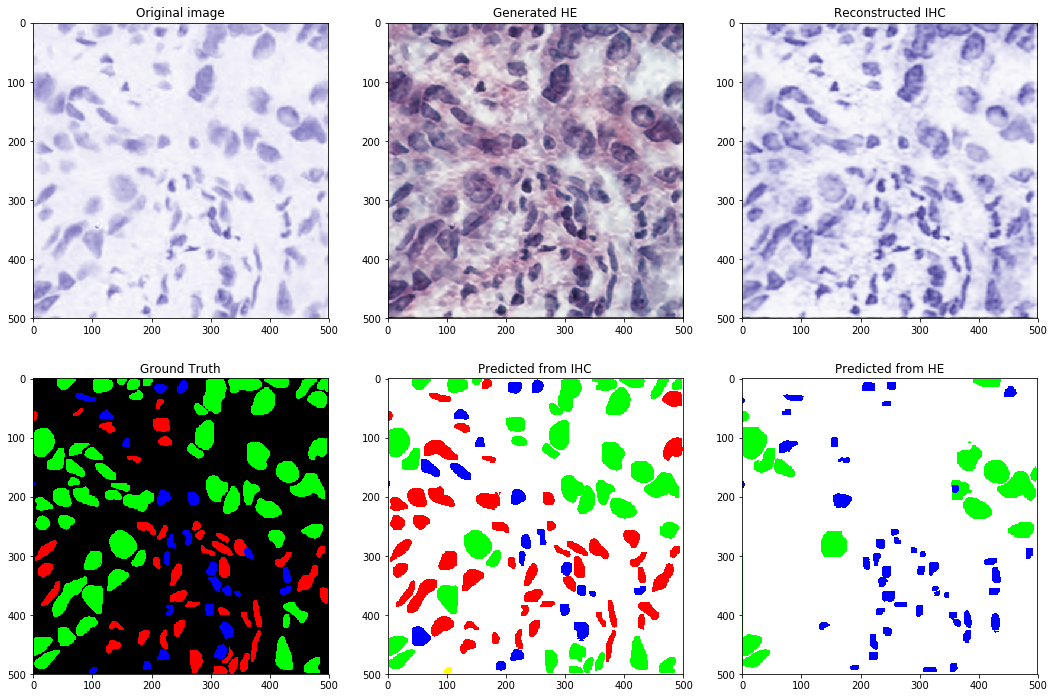

4 MDA LUAD-12 PD-L1 Tumor Microenviroment Prospect ADC-016.svs_7968.0x6896.851778656127.png


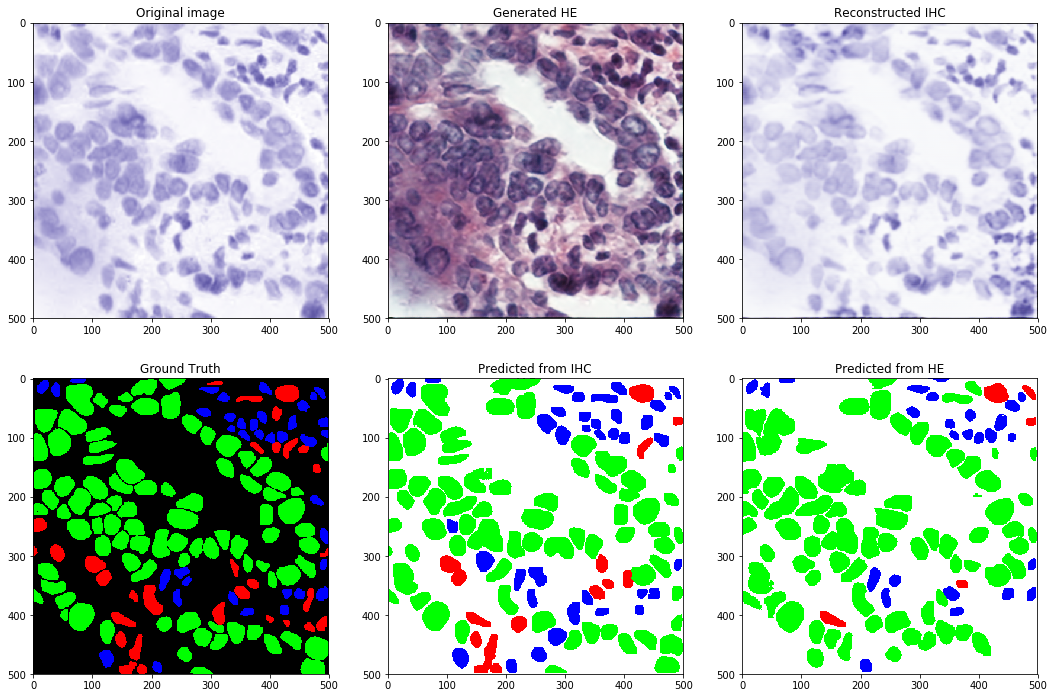

5 MDA LUAD-12 PD-L1 Tumor Microenviroment Prospect ADC-016.svs_11544.0x8000.98814229249.png


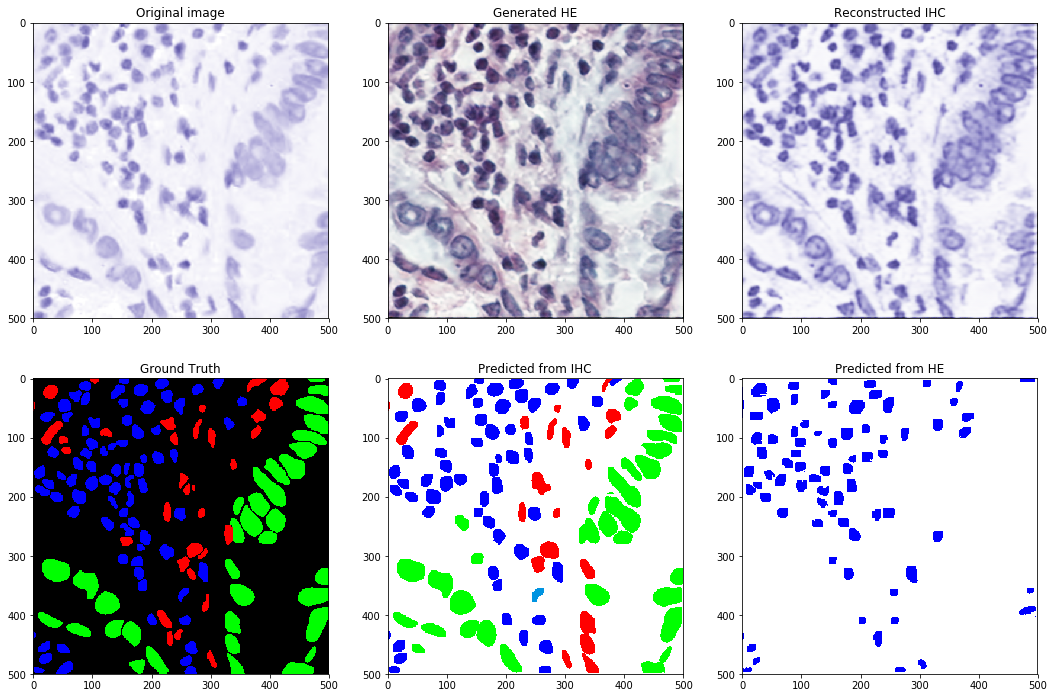

In [16]:
# For all testing images
mask_pred_real_As = []
mask_pred_fake_Bs = []
fake_Bs = []
rec_As = []
ground_truths = []
test_images = []

model.netG_B.eval()
model.netG_A.eval()

for i, ihc_index in enumerate(ihc_labeled_test):
    print(i, ihc_index)
    test_image = skimage.io.imread(os.path.join(image_dir, ihc_index))
    ground_truth = skimage.io.imread(os.path.join(mask_dir, ihc_index))
    ground_truth = normal_cell_to_stroma(rgba2rgb(ground_truth))
    
    # Preprocess
    test_image_normalized = preprocess(test_image, image_size=opt.crop_size).to(opt.gpu_ids[0])
    
    # Run detection
    with torch.no_grad():
        _, mask_pred_real_A, fake_B = model.netG_A([test_image_normalized], None)
        _, mask_pred_fake_B, rec_A = model.netG_B(fake_B, None)
    fake_B = np.transpose(np.array(np.clip(fake_B[0].detach().cpu().numpy()*255, 0, 255), 
                                                 dtype=np.uint8), (1, 2, 0))
    rec_A = np.transpose(np.array(np.clip(rec_A[0].detach().cpu().numpy()*255, 0, 255), 
                                                 dtype=np.uint8), (1, 2, 0))
    
    # Post-process (remove overlapped cells)
    mask_pred_real_A = postprocess(mask_pred_real_A[0], threshold=0, ori_image_size=test_image.shape[0])
    mask_pred_fake_B = postprocess(mask_pred_fake_B[0], threshold=0, ori_image_size=test_image.shape[0])
    fake_B = fake_B[0:test_image.shape[0], 0:test_image.shape[1], ...]
    rec_A = rec_A[0:test_image.shape[0], 0:test_image.shape[1], ...]
    
    # Plot
    plt.figure(figsize=(18, 12))
    plt.subplot(231)
    plt.imshow(test_image)
    plt.title("Original image")
    plt.subplot(232)
    plt.imshow(fake_B)
    plt.title("Generated HE")
    plt.subplot(233)
    plt.imshow(rec_A)
    plt.title("Reconstructed IHC")
    plt.subplot(234)
    plt.imshow(ground_truth)
    plt.title("Ground Truth")
    plt.subplot(235)
    display_segmentation(mask_pred_real_A, LABEL_TO_RGB)
    plt.title("Predicted from IHC")
    plt.subplot(236)
    display_segmentation(mask_pred_fake_B, LABEL_TO_RGB)
    plt.title("Predicted from HE")
    plt.show()
    
    mask_pred_real_As.append(mask_pred_real_A)
    mask_pred_fake_Bs.append(mask_pred_fake_B)
    fake_Bs.append(fake_B)
    rec_As.append(rec_A)
    ground_truths.append(ground_truth)
    test_images.append(test_image)

# 5) Evaluate image generator

## 5.1) AtoBtoA: IHC to HE to IHC

In [17]:
diffs = []
for ori, rec in zip(test_images, rec_As):
    diffs.append(np.average(np.abs(ori.astype(float)-rec.astype(float))))
print(np.average(diffs))
print(np.average(diffs)/255)

12.700210666666665
0.049804747712418294


# 6) Evaluate segmentation

In [18]:
def get_iou(y_true, y_pred):
    y_true, y_pred = y_true.flatten(), y_pred.flatten()
    nb_true, nb_pred = len(np.unique(y_true)), len(np.unique(y_pred))
    print("Number of ground truth vs. prediction:", [nb_true-1, nb_pred-1])
    
    # Calculate A_and_B, A_or_B and iou_score
    A_and_B = np.histogram2d(y_true, y_pred, bins=(nb_true, nb_pred))[0]
    A_or_B = (np.histogram(y_true, bins = nb_true)[0].reshape((-1, 1))
              + np.histogram(y_pred, bins = nb_pred)[0]
              - A_and_B) + 1e-8
    return (A_and_B / A_or_B)[1:, 1:]

from sklearn.metrics          import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [19]:
from segmentation_functions import RGB_to_index

RGB_markers = [[255, 255, 255],  # Background
               [0, 255, 0],  # Tumor
               [144, 0, 255], # Normal
               [255, 0, 0],  # Stroma
               [0, 0, 255],  # Lymphocyte
               [255, 0, 255],  # Blood cell
               [255, 255, 0],  # Macrophage
               [0, 148, 225]  # Dead nuclei
              ]
RGB_labels = [0, 1, 2, 2, 3, 4, 5, 6]

## 6.1) Segmentation results from HE (fake)

0
Number of ground truth vs. prediction: [139, 114]
Coverage: 0.7482014388489209
Coverage excluding blood & necrosis: 0.7482014388489209
Confusion matrix, without normalization
[[37  1  0  0]
 [ 9  5  2  0]
 [ 8  3 39  0]
 [ 0  0  0  0]]


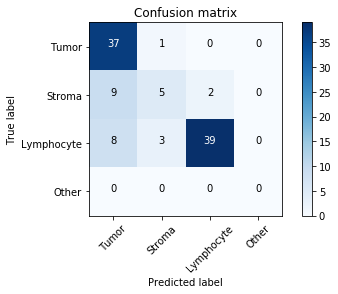

1
Number of ground truth vs. prediction: [100, 66]
Coverage: 0.57
Coverage excluding blood & necrosis: 0.57
Confusion matrix, without normalization
[[28  1  1  0]
 [ 6  2  1  0]
 [ 9  3  6  0]
 [ 0  0  0  0]]


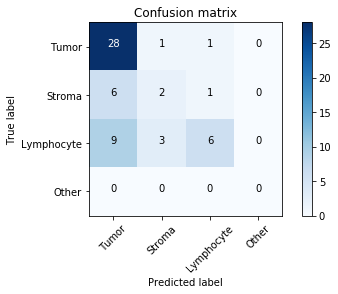

2
Number of ground truth vs. prediction: [88, 56]
Coverage: 0.5227272727272727
Coverage excluding blood & necrosis: 0.5
Confusion matrix, without normalization
[[30  0  6  0]
 [ 0  1  2  0]
 [ 2  0  1  0]
 [ 4  0  0  0]]


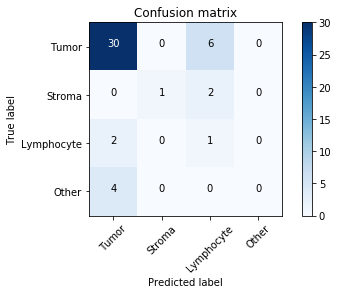

3
Number of ground truth vs. prediction: [121, 67]
Coverage: 0.34710743801652894
Coverage excluding blood & necrosis: 0.34710743801652894
Confusion matrix, without normalization
[[13  0  2  0]
 [ 1  0 12  0]
 [ 0  0 14  0]
 [ 0  0  0  0]]


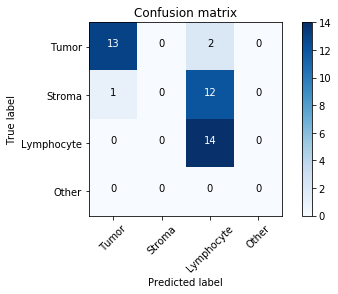

4
Number of ground truth vs. prediction: [157, 106]
Coverage: 0.6242038216560509
Coverage excluding blood & necrosis: 0.6242038216560509
Confusion matrix, without normalization
[[55  0  0  0]
 [ 9  3  1  0]
 [ 5  2 23  0]
 [ 0  0  0  0]]


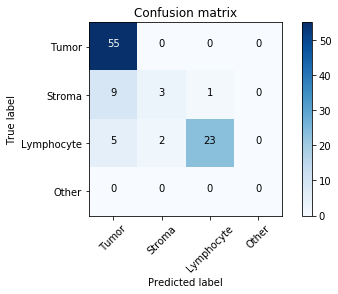

5
Number of ground truth vs. prediction: [145, 78]
Coverage: 0.42758620689655175
Coverage excluding blood & necrosis: 0.42758620689655175
Confusion matrix, without normalization
[[ 0  0  1  0]
 [ 0  0  8  0]
 [ 0  0 53  0]
 [ 0  0  0  0]]


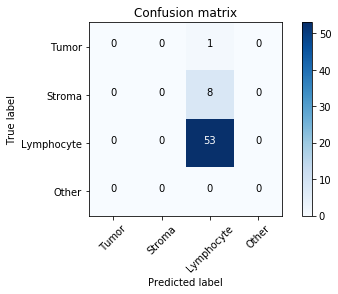

In [20]:
# For all testing images
n_cells_gt = []
n_matched = []
n_cells_excluding_blood_necrosis = []
n_cells_matched_excluding_blood_necrosis = []
iou_scores_matched_all = []
classes_matched_all = []
classes_matched_gt_all = []
classes_matched_gt_total_all = []

for i, ihc_labeled_test_id in enumerate(ihc_labeled_test):
    print(i)
    masks = mask_pred_fake_Bs[i]["masks"]
    classes = mask_pred_fake_Bs[i]["labels"]
    ground_truth = ground_truths[i]
    
    # Create a mask where each cell has a label
    mask = np.sum(np.array([masks[n_mask, :, :] * (n_mask + 1) for n_mask in range(np.shape(masks)[0])]), axis=0)
    
    ###### Evaluation ######
    
    # Create mask_gt and classes_gt
    mask_gt_index = RGB_to_index(ground_truth, RGB_markers=RGB_markers, RGB_labels=RGB_labels)
    mask_gt = np.zeros(np.shape(ground_truth)[0:2])
    classes_gt = []
    n_mask_gt = 0
    for RGB_label in np.unique(RGB_labels):
        if RGB_label == 0:
            # Skip background
            continue
        if not np.any(mask_gt_index == RGB_label):
            continue
        # Background is 0 in label; 4-connection
        label = skimage.measure.label(mask_gt_index == RGB_label, background=0, connectivity=1)
        for k in np.unique(label):
            if k == 0:
                continue
            mask_gt += (label == k) * (n_mask_gt + 1)
            classes_gt.append(RGB_label)
            n_mask_gt = n_mask_gt + 1
    classes_gt = np.array(classes_gt)
    
    # iou scores
    iou_scores = get_iou(mask_gt, mask)
    max_iou_score = np.max(iou_scores, axis=1)
    max_iou_id = np.argmax(iou_scores, axis=1)
    # print("iou scores", iou_scores)
    # print("max iou score", max_iou_score)
    # print("max iou id", max_iou_id)
    matched = np.where(max_iou_score > 0.5)[0]
    
    # Coverage
    print("Coverage: {}".format(len(matched)/n_mask_gt))
    print("Coverage excluding blood & necrosis: {}".
          format(len(set(list(matched)) - set(np.where((classes_gt == 4) | (classes_gt == 5) | (classes_gt == 6))[0]))/
                 len(np.where((classes_gt != 4) & (classes_gt != 5) & (classes_gt != 6))[0])))
    
    # Confusion matrix among tumor, stroma, lymphocyte, and other
    classes_matched = classes[max_iou_id[matched]]
    classes_matched_gt = classes_gt[matched]
    
    classes_matched_gt_total_all.extend(classes_matched_gt)
    
    classes_matched[classes_matched >= 4] = 4
    classes_matched_gt[classes_matched_gt >= 4] = 4
    
    # Plot confusion matrix
    cm = confusion_matrix(classes_matched_gt, classes_matched, labels=[1, 2, 3, 4])
    plot_confusion_matrix(cm, classes=["Tumor", "Stroma", "Lymphocyte", "Other"])
    
    # Set values
    n_cells_gt.append(n_mask_gt)
    n_matched.append(len(matched))
    n_cells_excluding_blood_necrosis.append(len(np.where((classes_gt != 5) & (classes_gt != 6))[0]))
    n_cells_matched_excluding_blood_necrosis.append(len(set(list(matched)) - 
                                                        set(np.where((classes_gt == 5) | (classes_gt == 6))[0])))
    iou_scores_matched_all.extend(max_iou_score[matched])
    classes_matched_all.extend(classes_matched)
    classes_matched_gt_all.extend(classes_matched_gt)

Coverage: 0.5453333333333333
Coverage excluding blood & necrosis: 0.5428954423592494
Total accuracy: 0.7579462102689487
Confusion matrix, without normalization
[[163   2  10   0]
 [ 25  11  26   0]
 [ 24   8 136   0]
 [  4   0   0   0]]


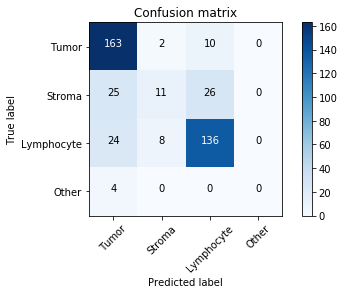

Normalized confusion matrix
[[0.93142857 0.01142857 0.05714286 0.        ]
 [0.40322581 0.17741935 0.41935484 0.        ]
 [0.14285714 0.04761905 0.80952381 0.        ]
 [1.         0.         0.         0.        ]]


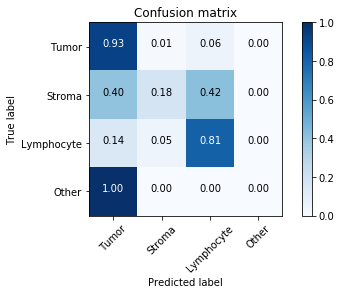

Mean iou:  0.7565781886355051
Mean iou for tumor cells:  0.7983634140408022
Mean iou for stroma cells:  0.7263053016820404
Mean iou for lymphocytes:  0.7226176979670641
Mean iou for macrophages:  nan
Mean iou for red blood cells:  0.8240449330069768
Mean iou for necrosis:  nan


/home2/swan15/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home2/swan15/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
# Total coverage
print("Coverage: {}".format(sum(n_matched)/sum(n_cells_gt)))
print("Coverage excluding blood & necrosis: {}".
      format(sum(n_cells_matched_excluding_blood_necrosis)/sum(n_cells_excluding_blood_necrosis)))

# Total confusion matrix
cm = confusion_matrix(classes_matched_gt_all, classes_matched_all, labels=[1, 2, 3, 4])
print("Total accuracy: {}".format((cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3])/np.sum(cm)))
plot_confusion_matrix(cm, classes=["Tumor", "Stroma", "Lymphocyte", "Other"])
plot_confusion_matrix(cm, classes=["Tumor", "Stroma", "Lymphocyte", "Other"], normalize=True)

# Mean iou
classes_matched_gt_all = np.array(classes_matched_gt_all)
classes_matched_gt_total_all = np.array(classes_matched_gt_total_all)
iou_scores_matched_all = np.array(iou_scores_matched_all)
print("Mean iou: ", np.mean(iou_scores_matched_all))
print("Mean iou for tumor cells: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 1)]))
print("Mean iou for stroma cells: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 2)]))
print("Mean iou for lymphocytes: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 3)]))
print("Mean iou for macrophages: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 4)]))
print("Mean iou for red blood cells: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 5)]))
print("Mean iou for necrosis: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 6)]))

## 6.2.1) Segmentation results from IHC

0
Number of ground truth vs. prediction: [139, 120]
Coverage: 0.8201438848920863
Coverage excluding blood & necrosis: 0.8201438848920863
Confusion matrix, without normalization
[[46  0  0  0]
 [ 9 10  3  0]
 [ 1  0 45  0]
 [ 0  0  0  0]]


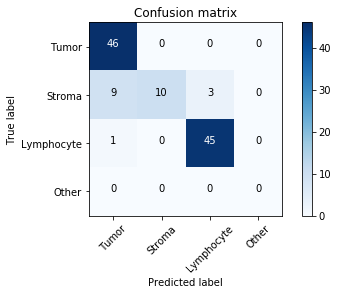

1
Number of ground truth vs. prediction: [100, 96]
Coverage: 0.91
Coverage excluding blood & necrosis: 0.91
Confusion matrix, without normalization
[[54  2  1  0]
 [ 4  5  2  0]
 [ 6  1 16  0]
 [ 0  0  0  0]]


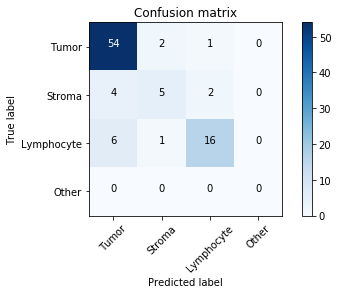

2
Number of ground truth vs. prediction: [88, 87]
Coverage: 0.9318181818181818
Coverage excluding blood & necrosis: 0.9285714285714286
Confusion matrix, without normalization
[[62  1  0  0]
 [ 6  3  0  0]
 [ 2  1  3  0]
 [ 3  0  0  1]]


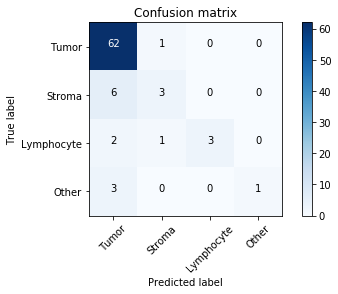

3
Number of ground truth vs. prediction: [121, 107]
Coverage: 0.8760330578512396
Coverage excluding blood & necrosis: 0.8760330578512396
Confusion matrix, without normalization
[[29 18  3  0]
 [ 6 26  0  0]
 [ 1  5 17  1]
 [ 0  0  0  0]]


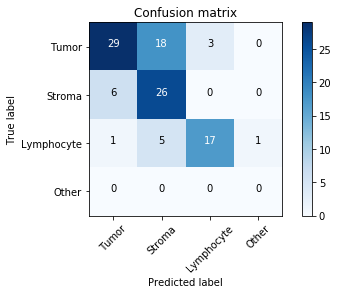

4
Number of ground truth vs. prediction: [157, 124]
Coverage: 0.7643312101910829
Coverage excluding blood & necrosis: 0.7643312101910829
Confusion matrix, without normalization
[[59  3  6  0]
 [ 6 11  2  0]
 [ 3  1 29  0]
 [ 0  0  0  0]]


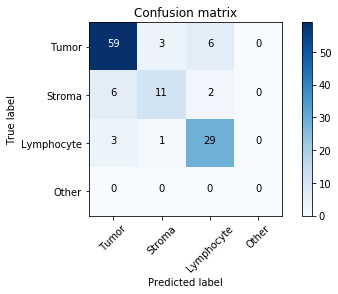

5
Number of ground truth vs. prediction: [145, 115]
Coverage: 0.7724137931034483
Coverage excluding blood & necrosis: 0.7724137931034483
Confusion matrix, without normalization
[[29  4  0  0]
 [ 2 15  2  0]
 [ 3  0 56  1]
 [ 0  0  0  0]]


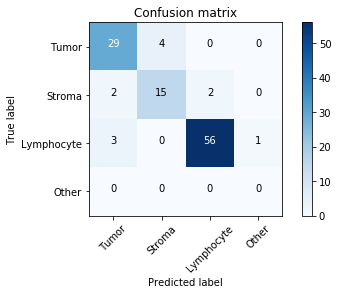

In [22]:
# For all testing images
n_cells_gt = []
n_matched = []
n_cells_excluding_blood_necrosis = []
n_cells_matched_excluding_blood_necrosis = []
iou_scores_matched_all = []
classes_matched_all = []
classes_matched_gt_all = []
classes_matched_gt_total_all = []

for i, ihc_labeled_test_id in enumerate(ihc_labeled_test):
    print(i)
    masks = mask_pred_real_As[i]["masks"]
    classes = mask_pred_real_As[i]["labels"]
    ground_truth = ground_truths[i]
    
    # Create a mask where each cell has a label
    mask = np.sum(np.array([masks[n_mask, :, :] * (n_mask + 1) for n_mask in range(np.shape(masks)[0])]), axis=0)
    
    ###### Evaluation ######
    
    # Create mask_gt and classes_gt
    mask_gt_index = RGB_to_index(ground_truth, RGB_markers=RGB_markers, RGB_labels=RGB_labels)
    mask_gt = np.zeros(np.shape(ground_truth)[0:2])
    classes_gt = []
    n_mask_gt = 0
    for RGB_label in np.unique(RGB_labels):
        if RGB_label == 0:
            # Skip background
            continue
        if not np.any(mask_gt_index == RGB_label):
            continue
        # Background is 0 in label; 4-connection
        label = skimage.measure.label(mask_gt_index == RGB_label, background=0, connectivity=1)
        for k in np.unique(label):
            if k == 0:
                continue
            mask_gt += (label == k) * (n_mask_gt + 1)
            classes_gt.append(RGB_label)
            n_mask_gt = n_mask_gt + 1
    classes_gt = np.array(classes_gt)
    
    # iou scores
    iou_scores = get_iou(mask_gt, mask)
    max_iou_score = np.max(iou_scores, axis=1)
    max_iou_id = np.argmax(iou_scores, axis=1)
    # print("iou scores", iou_scores)
    # print("max iou score", max_iou_score)
    # print("max iou id", max_iou_id)
    matched = np.where(max_iou_score > 0.5)[0]
    
    # Coverage
    print("Coverage: {}".format(len(matched)/n_mask_gt))
    print("Coverage excluding blood & necrosis: {}".
          format(len(set(list(matched)) - set(np.where((classes_gt == 4) | (classes_gt == 5) | (classes_gt == 6))[0]))/
                 len(np.where((classes_gt != 4) & (classes_gt != 5) & (classes_gt != 6))[0])))
    
    # Confusion matrix among tumor, stroma, lymphocyte, and other
    classes_matched = classes[max_iou_id[matched]]
    classes_matched_gt = classes_gt[matched]
    
    classes_matched_gt_total_all.extend(classes_matched_gt)
    
    classes_matched[classes_matched >= 4] = 4
    classes_matched_gt[classes_matched_gt >= 4] = 4
    
    # Plot confusion matrix
    cm = confusion_matrix(classes_matched_gt, classes_matched, labels=[1, 2, 3, 4])
    plot_confusion_matrix(cm, classes=["Tumor", "Stroma", "Lymphocyte", "Other"])
    
    # Set values
    n_cells_gt.append(n_mask_gt)
    n_matched.append(len(matched))
    n_cells_excluding_blood_necrosis.append(len(np.where((classes_gt != 5) & (classes_gt != 6))[0]))
    n_cells_matched_excluding_blood_necrosis.append(len(set(list(matched)) - 
                                                        set(np.where((classes_gt == 5) | (classes_gt == 6))[0])))
    iou_scores_matched_all.extend(max_iou_score[matched])
    classes_matched_all.extend(classes_matched)
    classes_matched_gt_all.extend(classes_matched_gt)

Coverage: 0.8333333333333334
Coverage excluding blood & necrosis: 0.8324396782841823
Total accuracy: 0.8256
Confusion matrix, without normalization
[[279  28  10   0]
 [ 33  70   9   0]
 [ 16   8 166   2]
 [  3   0   0   1]]


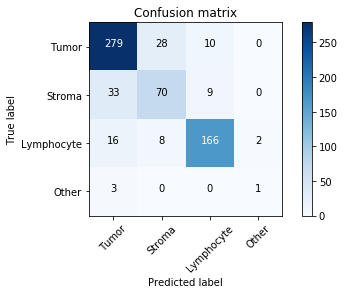

Normalized confusion matrix
[[0.88012618 0.08832808 0.03154574 0.        ]
 [0.29464286 0.625      0.08035714 0.        ]
 [0.08333333 0.04166667 0.86458333 0.01041667]
 [0.75       0.         0.         0.25      ]]


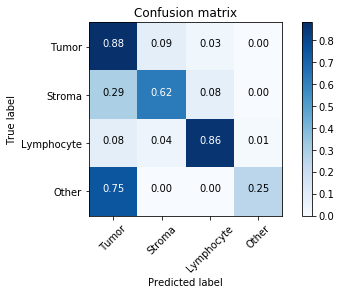

Total accuracy: 0.8319870759289176
Confusion matrix, without normalization
[[279  28  10]
 [ 33  70   9]
 [ 16   8 166]]


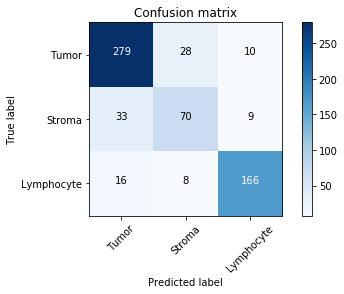

Normalized confusion matrix
[[0.88012618 0.08832808 0.03154574]
 [0.29464286 0.625      0.08035714]
 [0.08421053 0.04210526 0.87368421]]


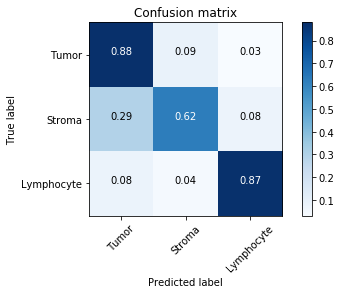

Mean iou:  0.8577893172667301
Mean iou for tumor cells:  0.8820958868160786
Mean iou for stroma cells:  0.8650047609171764
Mean iou for lymphocytes:  0.8132293422612743
Mean iou for macrophages:  nan
Mean iou for red blood cells:  0.8683400585302258
Mean iou for necrosis:  nan


In [23]:
# Total coverage
print("Coverage: {}".format(sum(n_matched)/sum(n_cells_gt)))
print("Coverage excluding blood & necrosis: {}".
      format(sum(n_cells_matched_excluding_blood_necrosis)/sum(n_cells_excluding_blood_necrosis)))

# Total confusion matrix
cm = confusion_matrix(classes_matched_gt_all, classes_matched_all, labels=[1, 2, 3, 4])
print("Total accuracy: {}".format((cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3])/np.sum(cm)))
plot_confusion_matrix(cm, classes=["Tumor", "Stroma", "Lymphocyte", "Other"])
plot_confusion_matrix(cm, classes=["Tumor", "Stroma", "Lymphocyte", "Other"], normalize=True)

# Total confusion matrix (exclude others)
cm = confusion_matrix(classes_matched_gt_all, classes_matched_all, labels=[1, 2, 3, 4])
print("Total accuracy: {}".format((cm[0, 0] + cm[1, 1] + cm[2, 2])/np.sum(cm[:3, :3])))
plot_confusion_matrix(cm[:3, :3], classes=["Tumor", "Stroma", "Lymphocyte"])
plot_confusion_matrix(cm[:3, :3], classes=["Tumor", "Stroma", "Lymphocyte"], normalize=True)

# Mean iou
classes_matched_gt_all = np.array(classes_matched_gt_all)
classes_matched_gt_total_all = np.array(classes_matched_gt_total_all)
iou_scores_matched_all = np.array(iou_scores_matched_all)
print("Mean iou: ", np.mean(iou_scores_matched_all))
print("Mean iou for tumor cells: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 1)]))
print("Mean iou for stroma cells: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 2)]))
print("Mean iou for lymphocytes: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 3)]))
print("Mean iou for macrophages: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 4)]))
print("Mean iou for red blood cells: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 5)]))
print("Mean iou for necrosis: ", np.mean(iou_scores_matched_all[np.where(classes_matched_gt_total_all == 6)]))

## 6.2.2) COCO evaluation

In [24]:
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Create COCOdataset
coco_gt = COCO()
coco_dt = COCO()
# annotation IDs need to start at 1, not 0, see torchvision issue #1530
ann_id_gt = 1
ann_id_dt = 1
dataset_gt = {'images': [], 'categories': [], 'annotations': []}
dataset_dt = {'images': [], 'categories': [], 'annotations': []}
categories = set()

for j, image_id in enumerate(ihc_labeled_test):
    img = test_images[j]
    img_dict = {}
    img_dict['id'] = image_id
    img_dict['height'] = img.shape[0]
    img_dict['width'] = img.shape[1]
    dataset_gt['images'].append(img_dict)
    dataset_dt['images'].append(img_dict)
    
    ############### Ground truth ###############
    target = ground_truths[j]
    target = normal_cell_to_stroma(rgba2rgb(target))
    objects = split_masks(target, val_to_label=RGB_TO_LABEL, dtype='float')
    if len(objects):
        target = np.transpose(np.array([x['mask'] for x in objects]), (1, 2, 0))
        labels = [x['label'] for x in objects]
    else:
        # Create a mask list [(h, w, 1)] and an empty label list
        target = np.zeros((image.shape[0], image.shape[1], 1))
        labels = []
    non_zeros = [(target[..., i], labels[i]) for i in range(len(labels)) if np.sum(target[..., i]) > 10]
    if len(non_zeros):
        target, labels = zip(*non_zeros)
    else:
        target = [np.zeros((self.crop_size, self.crop_size))]
        labels = []
    target = objects_to_tensor_targets(target, labels, i)
    target_gt = target
    bboxes = target_gt["boxes"]
    bboxes[:, 2:] -= bboxes[:, :2]
    bboxes = bboxes.tolist()
    labels = target_gt['labels'].tolist()
    areas = target_gt['area'].tolist()
    iscrowd = target_gt['iscrowd'].tolist()
    if 'masks' in target_gt:
        masks = target_gt['masks']
        # make masks Fortran contiguous for coco_mask
        masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
    num_objs = len(bboxes)
    for i in range(num_objs):
        ann = {}
        ann['image_id'] = image_id
        ann['bbox'] = bboxes[i]
        ann['category_id'] = labels[i]
        categories.add(labels[i])
        ann['area'] = areas[i]
        ann['iscrowd'] = iscrowd[i]
        ann['id'] = ann_id_gt
        if 'masks' in target_gt:
            ann["segmentation"] = coco_mask.encode(masks[i].numpy())
        dataset_gt['annotations'].append(ann)
        ann_id_gt += 1
    
    ############### Detection ###############
    target_dt = mask_pred_real_As[j]
    bboxes = target_dt["boxes"]
    bboxes[:, 2:] -= bboxes[:, :2]
    bboxes = bboxes.tolist()
    labels = target_dt['labels'].tolist()
    scores = target_dt['scores']
    iscrowd = list(np.zeros(len(labels), dtype=int))
    if 'masks' in target_dt:
        masks = target_dt['masks']
        # make masks Fortran contiguous for coco_mask
        masks = torch.tensor(masks, dtype=torch.uint8)
        masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
    num_objs = len(bboxes)
    for i in range(num_objs):
        ann = {}
        ann['image_id'] = image_id
        ann['bbox'] = bboxes[i]
        ann['category_id'] = labels[i]
        categories.add(labels[i])
        ann['area'] = np.sum(masks[i].numpy())
        ann['iscrowd'] = iscrowd[i]
        ann['id'] = ann_id_dt
        ann['score'] = scores[i]
        if 'masks' in target_dt:
            ann["segmentation"] = coco_mask.encode(masks[i].numpy())
        dataset_dt['annotations'].append(ann)
        ann_id_dt += 1
dataset_gt['categories'] = [{'id': _} for _ in sorted(categories)]
dataset_dt['categories'] = [{'id': _} for _ in sorted(categories)]
coco_gt.dataset = dataset_gt
coco_gt.createIndex()
coco_dt.dataset = dataset_dt
coco_dt.createIndex()

creating index...
index created!
creating index...
index created!


In [25]:
cocoEval = COCOeval(coco_gt, coco_dt, 'segm')
for catID in [[1], [2], [3], [5], [1, 2, 3, 5], [1, 2, 3]]:
    print(catID)
    cocoEval.params.catIds = catID
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

[1]
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.51s).
Accumulating evaluation results...
DONE (t=0.22s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDet

In [26]:
mean_ap = cocoEval.stats[0].item()
print(mean_ap)

0.39110951990098414


In [27]:
cocoEval = COCOeval(coco_gt, coco_dt, 'bbox')
for catID in [[1], [2], [3], [5], [1, 2, 3, 5], [1, 2, 3]]:
    print(catID)
    cocoEval.params.catIds = [catID]
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

[1]
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.49s).
Accumulating evaluation results...
DONE (t=0.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.129
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.420
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDet

In [28]:
mean_ap = cocoEval.stats[0].item() 
print(mean_ap)

0.3556359185189565


## 6.2.3) mIoU

In [29]:
# For all testing images
cm = np.zeros((len(CLASSES)+1, len(CLASSES)+1))

for i, ihc_labeled_test_id in enumerate(ihc_labeled_test):
    masks = mask_pred_real_As[i]["masks"]
    classes = mask_pred_real_As[i]["labels"]
    ground_truth = ground_truths[i]
    
    # Create a mask where each pixel has a label
    mask = np.sum(np.array([masks[n_mask, :, :] * classes[n_mask] for n_mask in range(np.shape(masks)[0])]), axis=0)
    mask_gt_index = RGB_to_index(ground_truth, RGB_markers=RGB_markers, RGB_labels=RGB_labels)
    
    # iou scores  (row: gt, column: pred)
    cm += np.histogram2d(mask_gt_index.flatten(), 
                                   mask.flatten(), 
                                   bins=(np.arange(len(CLASSES)+2), np.arange(len(CLASSES)+2)))[0]

IoUs = []
    
for class_id in range(1, len(CLASSES)+1):
    intersection = cm[class_id, class_id]
    union = np.sum(cm, axis=0)[class_id] + np.sum(cm, axis=1)[class_id] - intersection
    IoU = intersection/(union + 1e-8)
    IoUs.append(IoU)
    
print(IoUs)
print((IoUs[0] + IoUs[1] + IoUs[2])/3)

[0.7384598976707688, 0.3184345867629104, 0.5567809172992502, 0.0, 0.21184510250472965, 0.0]
0.5378918005776431


# Session Info

In [23]:
!pip freeze

absl-py==0.7.0
altair==3.2.0
argh==0.26.2
astor==0.7.1
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
autograd==1.2
backcall==0.1.0
base58==1.0.3
bleach==1.5.0
blinker==1.4
boto3==1.10.15
botocore==1.13.15
Bottleneck==1.2.1
cachetools==4.1.0
certifi==2019.3.9
chardet==3.0.4
Click==7.0
cvxopt==1.2.3
cvxpy==1.0.24
cycler==0.10.0
Cython==0.29.15
decorator==4.4.0
defusedxml==0.5.0
dill==0.2.9
docutils==0.15.2
ecos==2.0.7.post1
entrypoints==0.3
enum-compat==0.0.3
environment-kernels==1.1.1
FITS-tools==0.2
future==0.17.1
gast==0.2.2
google-auth==1.14.3
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
grpcio==1.29.0
h5py==2.10.0
html5lib==0.9999999
idna==2.8
image-registration==0.2.4
imageio==2.6.1
importlib-metadata==0.23
ipykernel==5.1.0
ipython==7.4.0
ipython-genutils==0.2.0
ipywidgets==7.4.2
isodate==0.6.0
jedi==0.13.3
Jinja2==2.10.1
jmespath==0.9.4
jsonschema==3.0.1
jupyter==1.0.0
jupyter-client==5.2.4
jupyter-console==6.0.0
jupyter-core==4.4.0
Keras==2.3.1
Keras-Applications==1.0.8
Ker